<h2> Environnement et définition de la problématique </h2>
 
Le domaine des paris sportifs fait de plus en plus d'adeptes grâce aux plateformes de jeux en ligne principalement mises à disposition par les bookmakers. Mais de nouvelles plateformes ont vu le jour(Datawin, Pronosoft) qui se basent uniquement sur des jeux de données pour établir les prédictions avec des taux de réussite de l'ordre de 75% (chiffres données par ces plateformes). Le dataset choisi utilise ici les cotes provenant des plateformes Pinnacle Sports et Bet365.

Plusieurs possibilités s’offrent à nous pour fixer l’objectif de ce projet.
La première possibilité est de vérifier s'il est possible de battre les pronostics des bookmakers. La cible est le résultat des matchs.
La deuxième possibilité est d’arriver à construire les cotes des bookmakers avec un taux de réussite supérieur. La cible est de construire les cotes des joueurs.


<h2>Structure du jeu de données</h2>
Nous avons à notre disposition les résultats sportifs de l’ATP pour les années 2000 à 2018 et également les cotes de deux bookmakers. Ce dataset est fourni par Edouard Thomas via Kaggle.com. Dans ce Dataset, les colonnes elo_winner, elo_loser et elo_proba sont calculées d’après les formules données par E.Thomas.

In [1]:
# importation des packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,learning_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report,accuracy_score,roc_curve
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier

# importation du fichier
#df = pd.read_csv('C:/Users/33781/Desktop/formation_Data _Analyst/Projet_paris_sportifs/dataset/atp_data.csv')
df=pd.read_csv('atp_data.csv')
# importation warnings pour ne pas avoir de messages de warning
import warnings
warnings.filterwarnings('ignore')



Chaque ligne du dataset correspond à un match opposant un joueur à un autre. Il s’agit uniquement de jeu en simple. 


Le dataset contient 23 colonnes dont les contenus sont :

- colonne 0 ATP : Nombre de tournoi(homme)
- colonne 1 Location : Lieu du match 
- colonne 2 Tournament : Nom du Tournoi 
- colonne 3 Date : date du match 
- colonne 4 Series : Nom de la série ATP 
- colonne 5 Court : extérieur ou intérieur 
- colonne 6 Surface : type de surface 
- colonne 7 Round : tour d'un match 
- colonne 8 Best of : nombre de sets maximum dans un match 3 ou 5 
- colonne 9 Winner : nom du gagnant 
- colonne 10 Loser : nom du perdant 
- colonne 11 WRank : classement ATP mondial du gagnant 
- colonne 12 LRank : classement ATP mondial du perdant 
- colonne 13 Wsets : nombre de sets gagnés pour le gagnant 
- colonne 14 Lsets : nombre de sets gagnés pour le perdant 
- colonne 15 Comment : issue du match 
- colonne 16 PSW : cote PINNACLE du gagnant 
- colonne 17 PSL : cote PINNACLE du perdant 
- colonne 18 B365W : cote B365 du gagnant 
- colonne 19 B365L : cote +B365 du perdant 
- colonne 20 elo_winner :Elo avant match du joueur gagnant 
- colonne 21 elo_loser : Elo avant match du joueur perdant 
- colonne 22 proba_elo : 1 / (1 + 10 ** ((elo_loser - elo_winner) / 400))

In [ ]:
df.describe()

### Etude de la variable elo

Les colonnes elo sont calculées ainsi :

- étape 1 : attribution d’un elo de 1500 à tous les joueurs.

puis pour chaque ligne
- étape 2 : calcul de la proba_elo : 1 / (1 + 10 ** ((elo_loser - elo_winner) / 400))
- étape 3 : calcul du elo_winner : elo_winner + 32 *(1-proba_elo)
- étape 4 : calcul du elo_loser : elo_loser - 32 *(1-proba_elo)

Avec cette méthode, nous comprenons que les différences s’accentuent avec le nombre de matchs joués

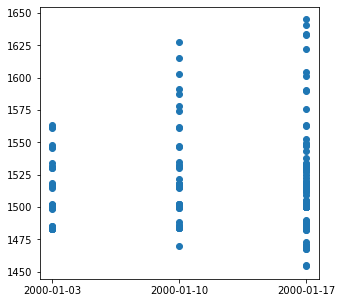

In [2]:
df['Year']=pd.to_datetime(df.Date).dt.year
df['Month']=pd.to_datetime(df.Date).dt.month
plt.figure(figsize=(5,5))
plt.scatter(df[(df['Year']==2000) & (df['Month']==1)]['Date'],df[(df['Year']==2000) & (df['Month']==1)]['elo_winner'])
plt.show()

La figure ci-dessus qui représente l’amplitude des elo des winners pour le mois de janvier 2000 (premier mois du dataset). Nous voyons que l’amplitude qui est de 80 pour le 3/1/2000 passe à 157 le 10/1/2000 et à 190 le 17/1/2000. Ces résultats sont difficiles à obtenir par simple observation du graphique, on peut certes en tirer une approximation pour avoir trouvé ces nombres (80, 157, 190), nous avons procédé à une différence de calcul dont le code est écrit ci-dessous.

In [3]:
print(df[df['Date']=='2000-01-03']['elo_winner'].max()-df[df['Date']=='2000-01-03']['elo_winner'].min())
print(df[df['Date']=='2000-01-10']['elo_winner'].max()-df[df['Date']=='2000-01-10']['elo_winner'].min())
print(df[df['Date']=='2000-01-17']['elo_winner'].max()-df[df['Date']=='2000-01-17']['elo_winner'].min())


80.03227825951262
157.60481483491844
190.99059264978996


## Etude sur les valeurs manquantes

In [4]:
df['Year']=pd.to_datetime(df.Date).dt.year
cols =['Wsets','Lsets','PSW','PSL','B365W','B365L']
df2=pd.DataFrame()
df3=pd.DataFrame(columns=['Wsets','Lsets','PSW','PSL','B365W','B365L'])
df2['count']= df['Date'].groupby(df['Year']).count()
for i in range(len(cols)):
    df2 = df2.join(df[cols[i]].isnull().groupby(df['Year']).sum(),how='right',lsuffix='_C')
    df3.iloc[:,i]=round((df[cols[i]].isnull().groupby(df['Year']).sum()*100/df2['count']),2)
df2=pd.concat([df2,df3],axis=1)
df2=df2.drop(['count'],axis=1)
df2

,Wsets,Lsets,PSW,PSL,B365W,B365L,Wsets,Lsets,PSW,PSL,B365W,B365L
Year,,,,,,,,,,,,
2000,0,0,2963,2963,2963,2963,0.00,0.00,100.00,100.00,100.00,100.00
2001,0,0,93,93,93,93,0.00,0.00,100.00,100.00,100.00,100.00
2002,0,0,2806,2806,1605,1605,0.00,0.00,100.00,100.00,57.20,57.20
2003,7,7,2816,2816,222,222,0.25,0.25,100.00,100.00,7.88,7.88
2004,8,8,179,179,275,275,0.28,0.28,6.22,6.22,9.56,9.56
2005,9,9,93,93,151,151,0.31,0.31,3.20,3.20,5.19,5.19
2006,12,12,74,74,137,137,0.41,0.41,2.54,2.54,4.71,4.71
2007,7,6,56,56,82,82,0.25,0.21,1.98,1.98,2.90,2.90
2008,19,19,48,48,37,37,0.71,0.71,1.79,1.79,1.38,1.38


Dans le tableau ci-dessus, les 6 colonnes de gauche contiennent le nombre de valeurs manquantes et les 6 colonnes de droites contiennent les % de valeurs manquantes par rapport au nombre total de lignes dans l’année.

Les valeurs manquantes pour Wsets et Lsets sont réparties presque uniformément de 2003 à 2018. Elles ne dépassent pas 1%. 
>hypothèse 1 : Nous pensons que le fait de remplacer ces valeurs ne devrait pas perturber le dataset.

Il manque l' ensemble des valeurs PSW et PSL pour les années 2000 à 2003 et 2009. 
>hypothèse 2: Nous pouvons essayer de trouver un moyen pour remplacer ces valeurs. La difficulté est de garder une cohérence dans les données. Une alternative est de savoir s’il est nécessaire de garder les cotes des deux bookmakers (PS et B365).

Il manque l’ensemble des valeurs B365W et B365L pour les années 2000 et 2001. Le pourcentage de valeurs manquantes pour 2002 est très important. Pour les autres années, les pourcentages des valeurs manquantes restent acceptables.
>hypothèse 3 : Pour les années 2000 et 2001 se pose le même problème que pour PSW et PSL.

Pour 2002, nous pouvons remplacer les valeurs manquantes. Mais il subsiste la possibilité qu’il n’y ait plus de cohérence dans les données. Pour les autres années, le pourcentage de valeurs manquantes reste faible. Nous pensons que le fait de remplacer ces valeurs ne devrait pas perturber le dataset.

Cette méthode d’analyse ne présuppose pas que nous allons traiter les valeurs manquantes par année.

## Matrice de corrélation

Text(0.5, 1.0, 'Matrice de correlation')

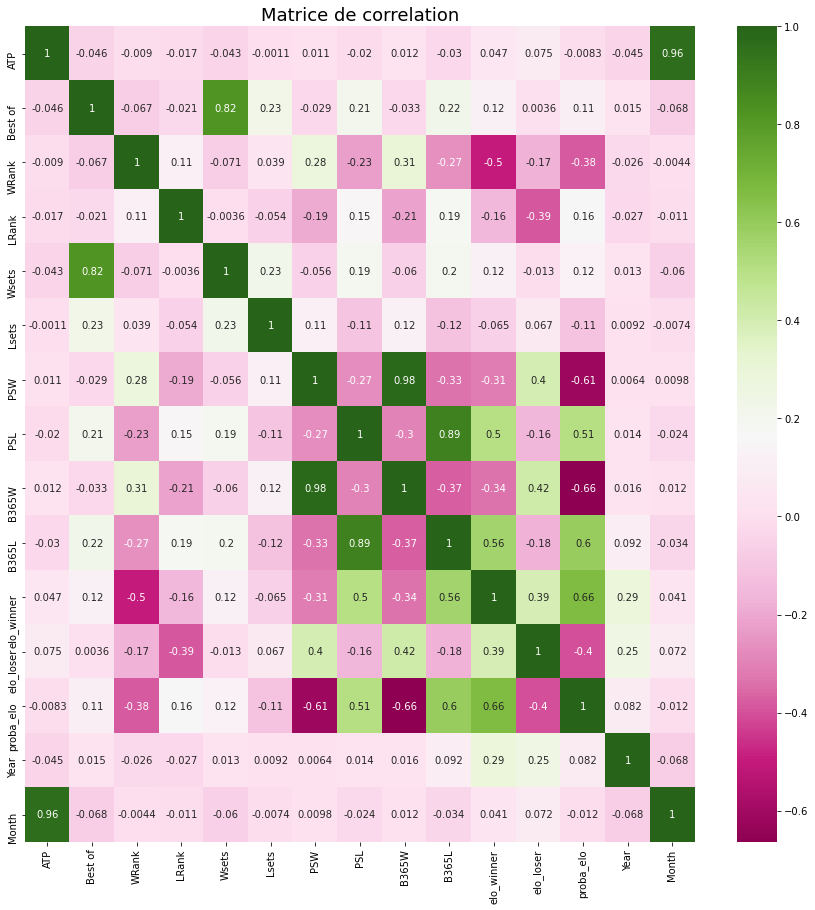

In [5]:
import seaborn as sns
plt.subplots(figsize = (15,15))
sns.heatmap(df.corr(), annot=True,cmap="PiYG")
plt.title("Matrice de correlation", fontsize = 18)

Nous constatons que les valeurs entre PSW et B365W sont très proches, c’est également le cas entre PSL et B365L. hypothèse 4 : Cela nous confirme que les valeurs d’un seul bookmaker pourraient suffire. Nous choisirons les cotes de Bet 365 car ces dernières possèdent moins de NaN que les cotes de Pinnacle Sports sur l’ensemble du dataset. Nous constatons que les corrélations entre la colonne ATP et les autres variables est très faible. Ce qui implique que cette colonne n’a pas de liens avec les autres. Par ailleurs elle n'apporte pas d’information pertinente sur les matchs. hypothèse 5 : Nous pouvons supprimer la colonne ATP.

En prenant les valeurs les plus fortes de chaque variable, nous constatons que : La variable Best of a une forte corrélation (0.82) avec la variable Wsets La variable WRank a une corrélation moyenne (-0.5) avec la variable elo_winner La variable LRank a une corrélation faible (-0;39) avec la variable elo_loser;

La variable Lsets n'a pratiquement aucun lien avec les autres variables hypothèse 6: Nous pouvons supprimer la colonne Lsets;

Les variables B365W et B365L ont une corrélation moyenne avec proba_elo (-0.66 et 0.6). La variable elo_loser a une faible corrélation (-0.39) avec la variable LRank et également une faible corrélation (0.4) avec la variable proba_elo.

La variable proba_elo a une forte corrélation avec B365W (-0.66) et B365L (0.6) et elo_winner(0.66).

En prenant le premier objectif pour ce projet, la target est de déterminer qui est le gagnant d’un match. Les colonnes Winner et Loser deviennent les targets.

En prenant le deuxième objectif pour ce projet, la target est de déterminer la cote du gagnant et la cote du perdant.

Dans tous les cas, il nous faudra déterminer quelles sont les relations avec toutes les variables.

<h1> Analyses et Visualisations </h1>

### Nombre de matchs par année

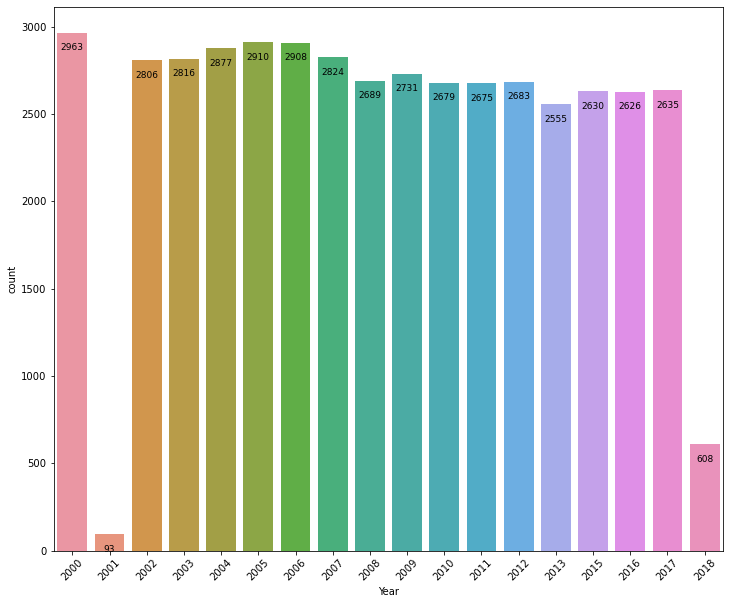

In [6]:
fig, ax1 = plt.subplots(figsize=(12,10))
sns.countplot(df['Year'], orient="h")

for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=9)
plt.xticks(rotation=45);

Nous constatons que les années 2001 et 2018 sont incomplètes.
Nous avons 2 hypothèses pour expliquer les variations du nombre de matchs par année.
hypothèse 1 : Certains tournois peuvent être supprimés ou ajoutés selon les années par les organisateurs.
hypothèse 2 : Dans le traitement des données réalisé en amont, certains matchs ont été supprimés ou non traités.

### Nombre de matchs par mois

Text(0.5, 1.0, 'Répartition des matchs par mois')

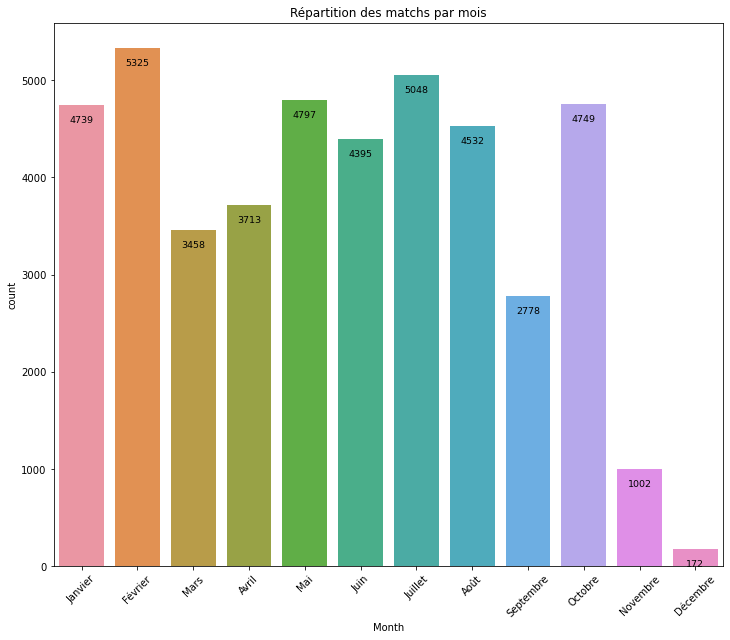

In [7]:
df['Month']=pd.to_datetime(df.Date).dt.month
fig, ax1 = plt.subplots(figsize=(12,10))
sns.countplot(df['Month'], x=[i for i in range(2,13,1)])
for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=9.5)

    
plt.xticks(np.arange(12), ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet','Août','Septembre','Octobre','Novembre','Décembre'])    
plt.xticks(rotation=45);
plt.title('Répartition des matchs par mois')

Le graphe ci-dessus montre une saisonnalité dans les rencontres qui correspond à la programmation des Grands Chelems.

### Top 10 des gagnants et Top 10 des perdants

Text(0.5, 1.0, 'Joueurs ayant le plus gagné entre Janvier 2000 et Mars 2018\n')

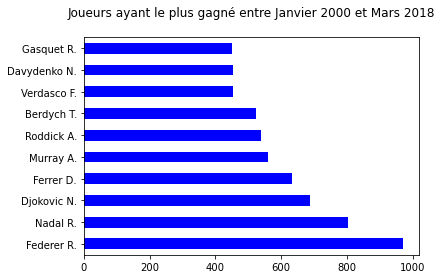

In [8]:
winner_top10 = df['Winner'].value_counts().head(10).plot(kind='barh', color = 'b')
plt.title('Joueurs ayant le plus gagné entre Janvier 2000 et Mars 2018\n')


Text(0.5, 1.0, 'Joueurs ayant le plus perdu entre Janvier 2000 et Mars 2018\n')

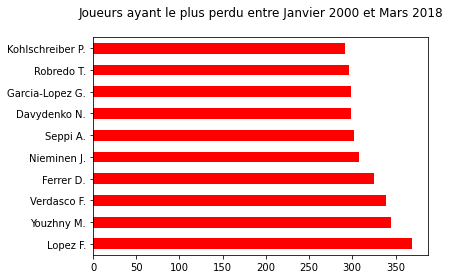

In [9]:
loser_top10 = df['Loser'].value_counts().head(10).plot(kind='barh', color = 'red')
plt.title('Joueurs ayant le plus perdu entre Janvier 2000 et Mars 2018\n')

On retrouve sur les 2 graphes Davydenko N et Ferrer D. 
Davydenko N a gagné environ 450 matchs et perdu 300 matchs
Ferrer D a gagné environ 650 matchs et perdu 325 matchs.
Si on retrouve ces deux joueurs dans les gagnants et les perdants, c’est parce qu’ils jouent plus de matchs que les autres du fait que les tournois font une sélection d’entrée.

### Nombre de tournois par surface

In [10]:
functions_to_apply = {'Tournament' : 'nunique'}
df.groupby('Surface').agg(functions_to_apply)

,Tournament
Surface,
Carpet,11
Clay,80
Grass,19
Hard,107


Les surfaces prédominantes sont le dur puis la terre battue. Cette analyse nous amènera à comparer les performances des joueurs pour une même surface.
On en déduit  que la grande majorité des matchs se déroulent sur surface dure et sur terre battue mais très peu sur gazon ou bien sur une surface moquette. 
Nous savons que Federer est le joueur ayant remporté le plus de matchs et que la surface prédominate est le dur donc suite à cela, on peut analyser un graphique comportant les meilleurs joueurs sur chaque type de surface mais la première hypothèse que l'on peut émettre c'est qu'on pense que Federer est le meilleur joueur sur le dur. Nous allons vérifier cela par la suite.

### Nombre de tournois gagnés par joueurs

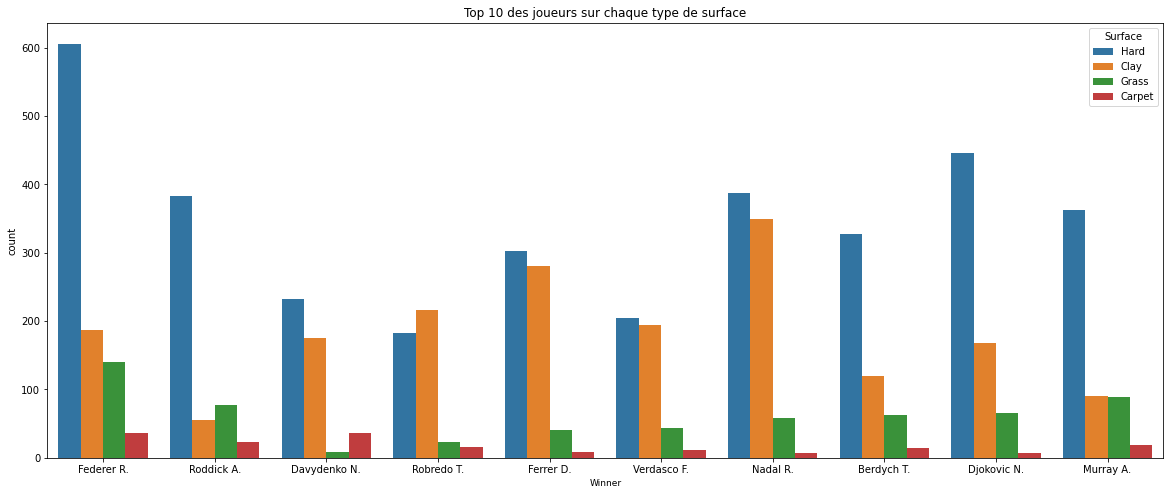

In [11]:
best_players = ('Federer R.', 'Nadal R.', 'Djokovic N.', 'Ferrer D.', 'Murray A.', 'Roddick A.', 'Berdych T.', 'Verdasco F.', 'Davydenko N.', 'Robredo T.')
players_surface = df.loc[df['Winner'].isin(best_players)]

fig,ax=plt.subplots(figsize = (20,8))
sns.countplot(players_surface['Winner'], hue = 'Surface', data=df)
ax.set_xlabel(xlabel = 'Winner', fontsize = 9)
plt.title('Top 10 des joueurs sur chaque type de surface')
plt.show();

Sur le dur, Federer domine les autres joueurs alors que sur terre battue, c’est Nadal qui domine. Chaque joueur a des préférences de surface, Federer est nettement meilleur sur le dur, alors que Nadal est pratiquement aussi bon sur le dur que la terre battue.

### Taux de bonnes prédictions des bookmakers

In [12]:
#On prend comme le joueur ayant la plus petit côte - donc le favori pour le bookmaker

df['good_prediction_PS'] = np.select([df['PSW'] < df['PSL'],df['PSW'] > df['PSL']], [1,0], default=0)
df['good_prediction_b365'] = np.select([df['B365W'] < df['B365L'],df['B365W'] > df['B365L']], [1,0], default=0)

#on divise la somme des bonnes prédictions par nb matchs

accuracy_PS = df.good_prediction_PS.sum() /len(df.Winner)
accuracy_B365 = df.good_prediction_b365.sum() /len(df.Winner)

df_new = df
df_new = df_new.dropna()

df_new['good_prediction_PS'] = np.select([df_new['PSW'] < df_new['PSL'],df_new['PSW'] > df_new['PSL']], [1,0], default=0)
df_new['good_prediction_b365'] = np.select([df_new['B365W'] < df_new['B365L'],df_new['B365W'] > df_new['B365L']], [1,0], default=0)
df_new.tail(10)

accuracy_PS_na = df_new.good_prediction_PS.sum() /len(df_new.Winner)
accuracy_B365_na = df_new.good_prediction_b365.sum() /len(df_new.Winner)

#On fait la même chose en enlevant les années avec NaN de B365
df_2003 = df

Years = [2000,2001,2002]

for i in Years:
    df_2003 = df_2003.drop(df[df['Year']==i].index)

df_2003['good_prediction_PS'] = np.select([df_2003['PSW'] < df_2003['PSL'],df_2003['PSW'] > df_2003['PSL']], [1,0], default=0)
df_2003['good_prediction_b365'] = np.select([df_2003['B365W'] < df_2003['B365L'],df_2003['B365W'] > df_2003['B365L']], [1,0], default=0)

accuracy_PS_2003 = df_2003.good_prediction_PS.sum() /len(df_2003.Winner)
accuracy_B365_2003 = df_2003.good_prediction_b365.sum() /len(df_2003.Winner)


#Calcul des tailles des échantillons 
size_df_na = df_new.shape[0] / (df.shape[0])
size_df_2003 = df_2003.shape[0]/ (df.shape[0])


#Création du dataframe
d = {'accuracy_PS': [accuracy_PS,accuracy_PS_na, accuracy_PS_2003], 'accuracy_B365': [accuracy_B365, accuracy_B365_na, accuracy_B365_2003],'dataset_size' : [1,size_df_na,size_df_2003]}
tab_pred = pd.DataFrame(data=d, index = ['full dataset', 'dropna','2003 to 2018'])

tab_pred


,accuracy_PS,accuracy_B365,dataset_size
full dataset,0.514002,0.602107,1.000000
dropna,0.702184,0.692927,0.720028
2003 to 2018,0.591567,0.672811,0.868883


La ligne “full dataset” représente le taux de bonnes prédictions sur l’ensemble du dataset sans suppression de lignes. Ce qui veut dire que les NaN sont comprises, notamment avec les années 2000 à 2002 où beaucoup de cotes sont manquantes. 
La ligne “dropna” représente le taux de bonnes prédictions sur le dataset diminué des lignes principalement pour les années 2000 à 2002 mais aussi 2003 et 2009. On observe une diminution de la taille du dataset de près de 28%.
Enfin la suppression des années 2000 à 2002 montre une différence conséquente entre le taux de bonnes prédictions de PS et B365. On peut l’expliquer principalement par les cotes manquantes PSW et PSL en 2003 et 2009.

# Dépendance des variables

## Dépendance des variables catégorielles

#### Test du chi2

In [13]:
# Sélection des variables à examiner
df_cat=df.select_dtypes(include=['object'])
df_cat=df_cat.drop(['Location','Tournament','Date','Winner','Loser'],axis=1)
df_num=df.select_dtypes(exclude=['object'])

In [14]:
# construction de la table de dépendance des valeurs catégorielles entre-elles
table = [[] for _ in range(df_cat.shape[1])]
k=-1
for i in df_cat.columns:
    k+=1
    for j in df_cat.columns:
        if i == j :
            table[k].append('V/V')
        else:
            cont_tab = pd.crosstab(df_cat[i], df_cat[j])
            st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont_tab)
            if st_p < .05 :
                table[k].append('L')
            else :
                table[k].append('NL')
Table=pd.DataFrame(table,index=df_cat.columns,columns=df_cat.columns)
Table

,Series,Court,Surface,Round,Comment
Series,V/V,L,L,L,L
Court,L,V/V,L,L,NL
Surface,L,L,V/V,L,NL
Round,L,L,L,V/V,L
Comment,L,NL,NL,L,V/V


Le test de Chi-Deux se réalise sur des variables qualitatives et le but de ce test est de savoir si les variables sont statistiquement liées ou non. Si on a rejet de H0, alors les 2 variables sont statistiquement liées et pour avoir rejet de H0, il faut que la p-value soit inférieur à 0.5, sinon cela signifierait que les 2 variables sont indépendantes.

V/V : valeur sur valeur
L : variables liées car p_value< 0.05
NL: variables non liées car p_value>0.05

#### Tests ANOVA

In [15]:
# test ANOVA
tennis_lm = ols('WRank ~ B365L + B365W + LRank + Wsets + Lsets + elo_winner + elo_loser + proba_elo', data=df).fit()
table = anova_lm(tennis_lm)
display(table)

,df,sum_sq,mean_sq,F,PR(>F)
B365L,1.0,1.449776e+07,1.449776e+07,4078.846156,0.000000e+00
B365W,1.0,1.032082e+07,1.032082e+07,2903.692178,0.000000e+00
LRank,1.0,7.781736e+06,7.781736e+06,2189.338617,0.000000e+00
Wsets,1.0,3.880867e+04,3.880867e+04,10.918557,9.529184e-04
Lsets,1.0,4.276407e+00,4.276407e+00,0.001203,9.723301e-01
elo_winner,1.0,2.908178e+07,2.908178e+07,8181.961182,0.000000e+00
elo_loser,1.0,4.164672e+05,4.164672e+05,117.170220,2.881729e-27
proba_elo,1.0,3.058509e+06,3.058509e+06,860.490723,4.215853e-187
Residual,38850.0,1.380876e+08,3.554378e+03,NaN,NaN


La variable WRank :

- est liée à la variable B365L
- est liée à la variable B365W
- est liée à la variable LRANK
- est liée à la variable Wsets
- est liée à la variable Lsets
- est liée à la variable elo_winner
- est liée à la variable elo_loser
- est liée à la variable proba_elo

# Préprocessing

### suppression colonnes ATP, PSW, PSL


In [16]:
# Suppression des colonnes inutiles
df=df.drop(['PSW','PSL','ATP', 'Year', 'Month'],axis=1)


La colonne ATP ne renvoie pas d’information pertinente par rapport au dataset. La suppression des colonnes PSW et PSL est dûe à notre choix de travailler uniquement avec les cotes de Bet 365.

### suppression des lignes années 2000, 2001 et 2002


In [17]:
# création variable Year pour sélectionner les lignes
df['Year']=pd.to_datetime(df.Date).dt.year
Years=[2000,2001,2002]

# suppression des lignes par années
for i in Years:
    df = df.drop(df[df.Year==i].index)
df=df.drop(['Year'],axis=1)

Les colonnes des cotes des bookmakers ( B365W, B365L) n'ont pas de valeurs sur plusieurs années. En supprimant les lignes des années 2000, 2001 et 2002, la perte d'informations est minimisée. Le remplacement par d'autres valeurs n'était pas pertinent, notamment l’utilisation du mean ou du mode semble biaiser l’ensemble.

### traitement des NaN : remplacement par la modalité la plus fréquente


In [18]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

Location                0.000000
proba_elo               0.000000
elo_loser               0.000000
elo_winner              0.000000
Comment                 0.000000
LRank                   0.000000
good_prediction_PS      0.000000
Loser                   0.000000
WRank                   0.000000
Best of                 0.000000
Round                   0.000000
Surface                 0.000000
Court                   0.000000
Series                  0.000000
Date                    0.000000
Tournament              0.000000
Winner                  0.000000
good_prediction_b365    0.000000
Wsets                   0.004814
Lsets                   0.004814
B365L                   0.025485
B365W                   0.026000
dtype: float64

On constate que ce sont les cotes B365L et B365 qui possèdent le plus de valeurs manquantes dans nos données. Pour palier à ce problème, nous optons pour le choix de remplacer les Nan par la modalité la plus fréquente dans la variable. En effet, si on supprime toutes les valeurs manquantes, cela engendrera une perte d'informations car plus on possède d'informations, meilleure sera la qualité de prédiction de nos modèles.

In [19]:
# sélection des colonnes avec des NaN
columns=['Wsets','Lsets','B365W','B365L']

# Suppression des NaN
for i in columns:
    df[i] = df[i].fillna(df[i].mode()[0])

### Suppression des outliers

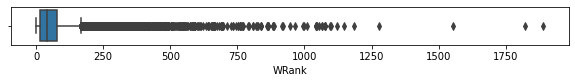

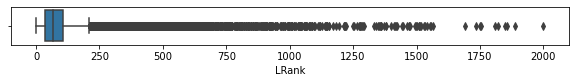

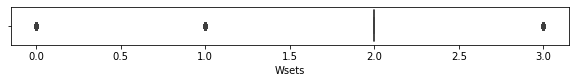

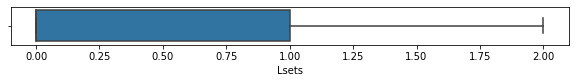

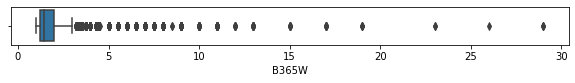

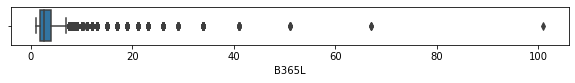

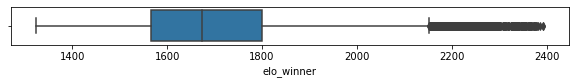

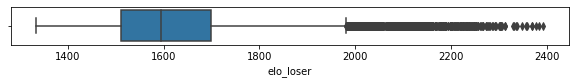

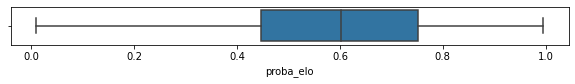

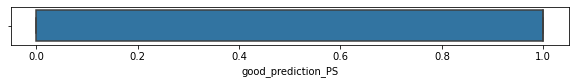

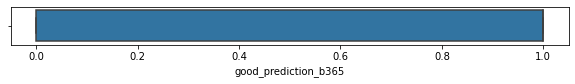

In [19]:
# Sélection des colonnes numérique
col_num=list(df.select_dtypes(exclude=['object']).columns)

# Boxplots des colonnes numériques
for i in range(1,len(col_num)):
    plt.figure(figsize=(10,10))
    plt.subplot(len(col_num),1,i)
    sns.boxplot(df[col_num[i]])
    plt.show()

Un outlier correspond  à une valeur éloignée de la distribution de la variable. La cause peut survenir en raison d'une erreur de typographie ou à une erreur de mesure mais cela peut également être une valeur extrême. Mais en général, parle de valeur extrême, c'est à dire une valeur non erronée qui s'éloigne fortement du reste des valeurs de la variable. Donc à partir de cette explication, on constate la présence de valeurs extrêmes pour les variables WRank ainsi que B365L,et comme nous utiliserons le Machine Learning par la suite, il faut donc supprimer ces valeurs extrêmes car pour obtenir une meilleure qualité de prédiction, il est nécessaire de traiter ces valeurs car un modèle peut être très sensible aux valeurs extrêmes ce qui va biaiser nos prédictions.

Nous supprimons les outliers selon les bornes suivantes :
- WRank : valeurs au delà de 1500
- LRank : pas d'outliers
- Wsets : pas d'outliers
- Lsets : pas d'outliers
- B365W : pas d'outliers
- B365L : valeurs au delà de 80
- elo_winner : pas d'outliers
- elo_loser : pas d'outliers
- proba_elo : pas d'outliers

In [20]:
# Suppression des outliers selon les indications précédentes
df.drop(df[df.WRank>1500].index,inplace=True)
df.drop(df[df.B365L>80].index,inplace=True)

Maintenant que nous avons analysé notre dataset et utiliser le préprocessing, nous allons désormais passer à la modélisation pour le scénario 1.

# Scénario 1

L'objectif de ce scénario est d’arriver à battre les bookmakers avec un taux de réussite supérieur.

Choix de la cible

In [21]:
df['test_rank']=df.WRank>df.LRank
df['test_sets']=df.Wsets>df.Lsets
df['test_B365']=df.B365W<df.B365L
df['test_elo']=df.elo_winner>df.elo_loser

In [22]:
print(df.test_rank.value_counts())
print(df.test_sets.value_counts())
print(df.test_B365.value_counts())
print(df.test_elo.value_counts())

False    25594
True     13248
Name: test_rank, dtype: int64
True     38321
False      521
Name: test_sets, dtype: int64
True     27144
False    11698
Name: test_B365, dtype: int64
True     25956
False    12886
Name: test_elo, dtype: int64


La cible la plus appropriée est le Rank des joueurs. Cette cible est une variable quantitative donc on aura recours à des modèles de régression linéaire ici.

Il faut transformer le dataset pour avoir une ligne par joueur.

In [23]:
df.drop(['test_rank','test_sets','test_B365','test_elo'],inplace=True,axis=1)

## Transformation du dataset pour avoir une ligne par joueur

In [24]:
# Séparation des colonnes des winners avec les colonnes des losers
df_win=df.drop(['LRank','Lsets','B365L','elo_loser','Loser'],axis=1)
df_los=df.drop(['WRank','Wsets','B365W','elo_winner','Winner'],axis=1)

# Renommage des colonnes
df_win=df_win.rename(columns={'WRank':'Rank','Wsets':'sets','B365W':'B365','elo_winner':'elo','Winner':'Player'}).reset_index()
df_los=df_los.rename(columns={'LRank':'Rank','Lsets':'sets','B365L':'B365','elo_loser':'elo','Loser':'Player'}).reset_index()

# création colonne target pour scénario 2
df_win['target']=1
df_los['target']=0

# création du dataframe
df1=pd.concat([df_win,df_los],axis=0,ignore_index=True)
df1.drop('index',inplace=True,axis=1)

#création du dataframe du scénario 1
df2=df1.copy()
df2.drop(['target'],axis=1)

,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Player,Rank,sets,Comment,B365,elo,proba_elo,good_prediction_PS,good_prediction_b365
0,Chennai,TATA Open,2003-01-01,International,Outdoor,Hard,2nd Round,3,Srichaphan P.,16,2.0,Completed,1.143,1799.875080,0.837390,0,1
1,Chennai,TATA Open,2003-01-01,International,Outdoor,Hard,2nd Round,3,Sargsian S.,103,2.0,Completed,1.667,1502.556682,0.547476,0,1
2,Chennai,TATA Open,2003-01-01,International,Outdoor,Hard,2nd Round,3,Chela J.I.,23,1.0,Retired,1.333,1628.226998,0.693453,0,1
3,Adelaide,AAPT Championships,2003-01-01,International,Outdoor,Hard,1st Round,3,Squillari F.,79,2.0,Completed,2.500,1524.950421,0.315561,0,0
4,Adelaide,AAPT Championships,2003-01-01,International,Outdoor,Hard,1st Round,3,Gasquet R.,161,2.0,Completed,1.360,1468.802644,0.455224,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77679,Dubai,Dubai Tennis Championships,2018-03-03,ATP500,Outdoor,Hard,The Final,3,Pouille L.,15,0.0,Completed,2.200,1842.459807,0.490563,1,1
77680,Acapulco,Abierto Mexicano,2018-03-03,ATP500,Outdoor,Hard,Semifinals,3,Donaldson J.,59,1.0,Completed,3.500,1647.967561,0.755103,1,1
77681,Sao Paulo,Brasil Open,2018-03-03,ATP250,Indoor,Clay,Semifinals,3,Zeballos H.,69,1.0,Completed,1.900,1619.758421,0.454841,1,0
77682,Acapulco,Abierto Mexicano,2018-03-04,ATP500,Outdoor,Hard,The Final,3,Anderson K.,8,0.0,Completed,2.620,1851.413609,0.659862,1,1


In [25]:
# Séparation target /data
target=df2.Rank
df2.drop('Rank',inplace=True,axis=1)

## Standardisation

In [26]:
df2.describe()

,Best of,sets,B365,elo,proba_elo,good_prediction_PS,good_prediction_b365,target
count,77684.000000,77684.000000,77684.000000,77684.000000,77684.000000,77684.000000,77684.000000,77684.000000
mean,3.375109,1.272192,2.683125,1661.033609,0.592157,0.591576,0.672828,0.500000
std,0.780717,1.008361,2.714284,167.867928,0.205134,0.491545,0.469184,0.500003
min,3.000000,0.000000,1.000000,1323.901480,0.008899,0.000000,0.000000,0.000000
25%,3.000000,0.000000,1.360000,1532.209410,0.446655,0.000000,0.000000,0.000000
50%,3.000000,2.000000,1.830000,1633.060334,0.601524,1.000000,1.000000,0.500000
75%,3.000000,2.000000,2.870000,1751.149279,0.751914,1.000000,1.000000,1.000000
max,5.000000,3.000000,67.000000,2392.595567,0.995601,1.000000,1.000000,1.000000


Les différences d'échelles entre les variables quantitatives nécessitent de faire une standardisation ce qui va permettre d'équilibrer le poids des chacune des variables au sein de notre DataFrame.

Les colonnes suivantes sont normalisées :
'Best of',  'Rank',  'sets',  'B365',  'proba_elo'

In [27]:
# Séparation des données quantitatives et qualitatives
df2_num=df2.select_dtypes(exclude=['object'])
df2_cat=df2.select_dtypes(include=['object'])

In [28]:
# standardisation des données numériques
sc=StandardScaler()
df_sc=pd.DataFrame(sc.fit_transform(df2_num),columns=list(df2_num.columns))
df2=pd.concat([df_sc,df2_cat],axis=1)

## Sélection des colonnes

In [29]:
# Affichage du nobre de modalités par variable
for i in df2_cat:
    print(i,df2_cat[i].value_counts().count())

Location 103
Tournament 176
Date 4025
Series 8
Court 2
Surface 4
Round 8
Player 1239
Comment 4


- La variable Location contient 103 modalités. Elle ne peut pas être discretisée: elle est supprimée.
- La variable Tournament contient 176 modalités. Elle ne peut pas être discretisée: elle est supprimée.
- La variable Date n'est pas nécessaire à la modélisation, elle est supprimée.
- La variable Series contient 8 modalités, elle est discretisée.
- La variable Court contient 2 modalités, elle est discretisée.
- La variable Surface contient 4 modalités, elle est discretisée.
- La variable Round contient 8 modalités, elle est discretisée.
- La variable Player contient 1239 modalités. Elle ne peut pas être discretisée: elle est supprimée.
- La variable Comment contient 4 modalités, elle est discretisée.

In [30]:
# Suppression des colonnes indiquées précedement
df2=df2.drop(['Location','Tournament','Date','Player'],axis=1)

# Discretisation des colonnes qualitatives
df2 = pd.get_dummies(df2, prefix=['Ser','Cou','Sur','Rou','Com'], columns=['Series','Court','Surface','Round','Comment'])

Dans ce scénario, nous utilisons la colonne Rank comme cible.

Il s'agit d'une Regression.
Nous allons tester les algorithmes suivants :


- Ridge
- LinearRegression

In [31]:
from sklearn.model_selection import train_test_split
# Jeux de train et test
X_train,X_test,y_train,y_test=train_test_split(df2,target,test_size=0.2,random_state=101)

## Modèle RidgeCV

In [32]:
# Importation des packages
from sklearn.linear_model import RidgeCV

In [33]:
# Recherche du meilleur alpha
mes_alphas=(0.000001,0.00001,0.0001,0.001,0.01,0.02,0.025)
Rcv = RidgeCV(alphas=mes_alphas,normalize=False,fit_intercept=False,cv=10)
Rcv.fit(X_train,y_train)
print('meilleur alpha',Rcv.alpha_)

meilleur alpha 0.025


In [34]:
y_pred=Rcv.predict(X_test)

#### Evaluation du modèle

In [35]:
print(Rcv.score(X_test,y_test))

0.24314766740328708


## Modèle LinearRegression

In [36]:
# Importation des packages
from sklearn.linear_model import LinearRegression

In [37]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

#### Evaluation du modèle

In [38]:
print(lr.score(X_test,y_test))

0.2427122323494597


Nous obtenons des scores égal à 0.24 pour nos deux modèles, ce qui est très faible, nous allons maintenant voir si le score obtenu avec le scénario 2 est meilleur.

# Scénario 2

L'objectif de ce scénario est de vérifier s'il est possible de battre les pronostics des bookmakers. 
La cible est le résultat des matchs.

Dans ce scénario, nous créons une nouvelle colonne target comme cible.

Elle contient les valeurs suivantes :
1 pour le gagnant et 0 pour le perdant.

# Réorganisation du dataset

## Attribution d'un id à chaque joueur
On cherche ici à créer une colonne pour chaque joueur sous forme numérique. En effet, cela pourra être utile pour l'étape de modélisation, notamment pour la transformation d'une variable objet en variable numérique concernant les colonnes Winner et Loser.

In [39]:
# création de 2 dataset contenant les winner et les loser

noms_winner = (df.Winner.value_counts().index)
noms_loser = (df.Loser.value_counts().index)

joueurs_w = pd.DataFrame({'joueurs' : noms_winner})
joueurs_l = pd.DataFrame({'joueurs' : noms_loser})

frame = [joueurs_w,joueurs_l]

# création d'un dataset regroupant l'ensemble des joueurs
agg_noms_joueurs = pd.concat(frame)

# création d'une liste contenant les noms des joueurs sans doublons
noms = agg_noms_joueurs.value_counts().rename_axis('noms_p').reset_index(name='counts')

noms['number_id'] = [i for i in range(noms.shape[0])]
noms = noms.drop('counts', axis = 1)

# création des colonnes loser_id et Winner_id contenant les id de chaque joueur
replace_dict = dict(noms.to_dict('split')['data'])
df['loser_id'] = df['Loser'].map(replace_dict)
df['winner_id'] = df['Winner'].map(replace_dict)

## Remaniement des colonnes pour créer la target
On cherche ici à obtenir l'ensemble des résultats pour les matchs joués du dataset. Pour cela, on va devoir doubler la taille de notre dataset afin d'obtenir toutes les victoires mais aussi toutes les défaites des joueurs. En suivant cette démarche on va pouvoir regrouper l'ensemble des résultats dans une seule colonne qui sera notre variable target par la suite. 

### Création de 2 datasets pour avoir une Target à 1 pour les gagnants et à 0 pour les perdants

In [40]:
#On attribue le 'first_player' à la colonne loser_id
df_1 = df.copy()
df_1 = df_1.rename(columns={"loser_id": "first_player", "elo_loser": "first_elo", "B365L": "first_odds",
                        "LRank": "first_rank","winner_id": "second_player", "elo_winner": "second_elo", "B365W": "second_odds",
                        "WRank": "second_rank"                  
                       },)
# création colonne Player pour calcul moyenne roulante
df_1['Player']=df['Winner']

#On associe le 'second_player' à la colonne loser_id
df_2 = df.copy()
df_2  = df_2.rename(columns={"loser_id": "second_player", "elo_loser": "second_elo", "B365L": "second_odds",
                        "LRank": "second_rank","winner_id": "first_player", "elo_winner": "first_elo", "B365W": "first_odds",
                        "WRank": "first_rank"                     
                       },)

# création colonne Player pour calcul moyenne roulante
df_2['Player']=df['Loser']

### Construction du dataset avec la variable target 

La variable target détermine le vainqueur d'une confrontation en prenant la valeur 1 pour une victoire et 0 pour une défaite. 
Quand le premier joueur gagne target = 1. A l’inverse, quand le premier joueur perd target = 0, ce qui revient à dire que si le deuxième joueur gagne, target = 0.

In [41]:
winner_player2 = np.zeros(df_1.shape[0]) # second player wins so label=0
df_1['target'] = winner_player2

winner_player1 = np.ones(df_2.shape[0]) # second player wins so label=0
df_2['target'] = winner_player1

data = pd.concat([df_1,df_2],ignore_index=True)

target= data['target']
data.drop(['target'], axis = 1,inplace=True)

In [42]:
# copie de data pour le scénario alternatif incluant les moyennes roulantes/mobile
data_roulante =data.copy()
data_paris=data.copy()
data_paris['target']=target
# suppression des colonnes inutiles ou redondantes
data=data.drop(['Date','Location','Wsets','Lsets','Comment','proba_elo','Winner','Loser','Player','good_prediction_PS','good_prediction_b365'],axis=1)

- La variable Player est supprimée car elle ne sert qu'au calcul de la moyenne roulante.
- Les variables Winner et Loser sont supprimées car les noms des joueurs sont remplacées par leur id. 

## Transformation des variables objets en variables numériques

In [43]:
le= LabelEncoder()
data['Series'] = le.fit_transform(data['Series'].astype(str))
data['Court'] = le.fit_transform(data['Court'].astype(str))
data['Tournament'] = le.fit_transform(data['Tournament'].astype(str))
data['Surface'] = le.fit_transform(data['Surface'].astype(str))
data['Round'] = le.fit_transform(data['Round'].astype(str))

### Fonctions

In [44]:
# évaluations des modèles
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('Matrice de confusion :')
    print(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
    print('\n \n Classification Report :')
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(17,6))                          
    plt.title('Learning_curve')
    plt.xlabel("Train_set")
    plt.ylabel("Score")                     
                                
    train_sizes, train_scores, test_scores = learning_curve(model,X_train,y_train,cv=4,n_jobs=-1,train_sizes=np.linspace(0.1, 1.0, 10))
                              
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Graphe de la learning_curve
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    plt.show();

def affichage_roc (x,y,xlabel,ylabel,label,title):
    figure,axes=plt.subplots(figsize=(17,6))
    axes.plot(x,y,label=label)
    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.plot([0, 1], [0, 1], color='black', linestyle='--')
    axes.legend();

def affichage (x,y,xlabel,ylabel,label,title):
    figure,axes=plt.subplots(figsize=(17,6))
    axes.plot(x,y,label=label)
    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.legend();

## Modèle RandomForest

In [45]:
# Création d'un ensemble d'entraînement et d'un ensemble test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

## Application du modèle RandomForest 

#### représentation du score en fonction du nombre d'estimateurs

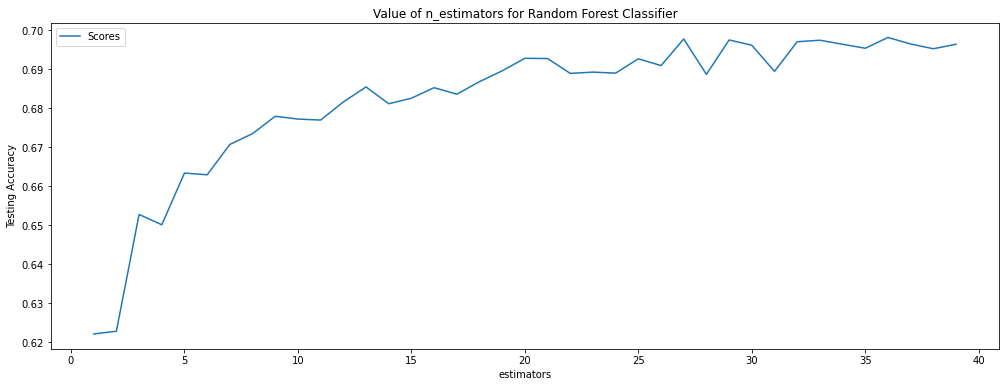

In [46]:
#recherche du n_estimators optimal avec le modèle RandomForestClassfier
scores =[]
for k in range(1, 40):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

#Affichage graphique entre l'accuracy et n_estimators
affichage(range(1, 40), scores,'estimators','Testing Accuracy','Scores','Value of n_estimators for Random Forest Classifier')

On peut observer une forte augmentation de l’accuracy entre 0 et 20 n puis un début de stagnation lorsque n>20 avec l’accuracy entre 68% et 70%.

Matrice de confusion :
Classe prédite   0.0   1.0
Classe réelle             
0.0             5489  2184
1.0             2510  5354

 
 Classification Report :
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70      7673
         1.0       0.71      0.68      0.70      7864

    accuracy                           0.70     15537
   macro avg       0.70      0.70      0.70     15537
weighted avg       0.70      0.70      0.70     15537



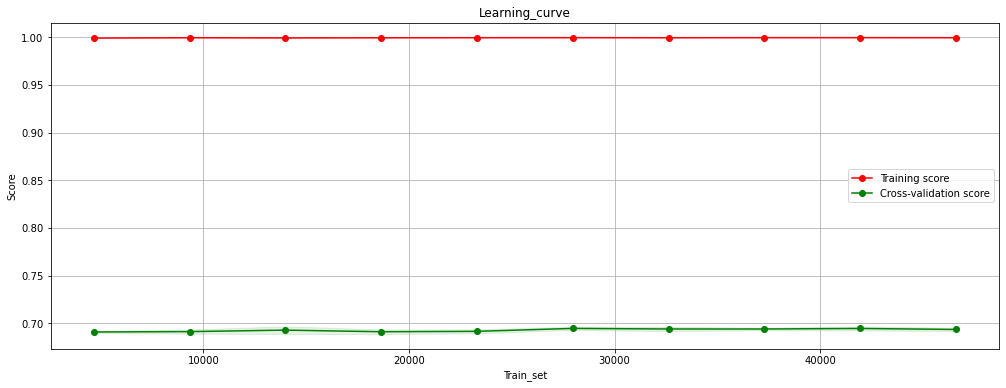

In [47]:
RF_clf = RandomForestClassifier(n_estimators=40,random_state = 22)
evaluation(RF_clf)

#### Interpretation
- Matrice de confusion
>Nous avons à peu près un tiers de mauvaises prédictions aussi bien pour les matchs gagnés que les matchs perdus.
 

    
- Classification report
>On observe une précision, un recall et un f1-score convenables en correspondance avec la matrice de confusion.

- Learning-curve
>A partir d'un train_set d'environ 15000 valeurs, les résultats restent identiques. Le score du test_set est moins bon mais reste acceptable. On observe ici un phénomène d’overfitting, le modèle est plus performant sur l’échantillon d’entrainement de près de 10%. 

### Optimisation du modèle

In [48]:
params_grid_rf  = {'min_samples_leaf': [i for i in range(1,10,1)],'max_features': ['sqrt', 'log2',None],'n_estimators':[i for i in range(1,40)]}

gridcv_rf = GridSearchCV(RF_clf, param_grid=params_grid_rf, scoring='accuracy', cv=4,n_jobs=-1).fit(X_train, y_train)

In [49]:
print('\n \n best_param ',gridcv_rf.best_params_)


 
 best_param  {'max_features': 'sqrt', 'min_samples_leaf': 9, 'n_estimators': 39}


### Application des best_params

Matrice de confusion :
Classe prédite   0.0   1.0
Classe réelle             
0.0             5425  2248
1.0             2323  5541

 
 Classification Report :
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.70      7673
         1.0       0.71      0.70      0.71      7864

    accuracy                           0.71     15537
   macro avg       0.71      0.71      0.71     15537
weighted avg       0.71      0.71      0.71     15537



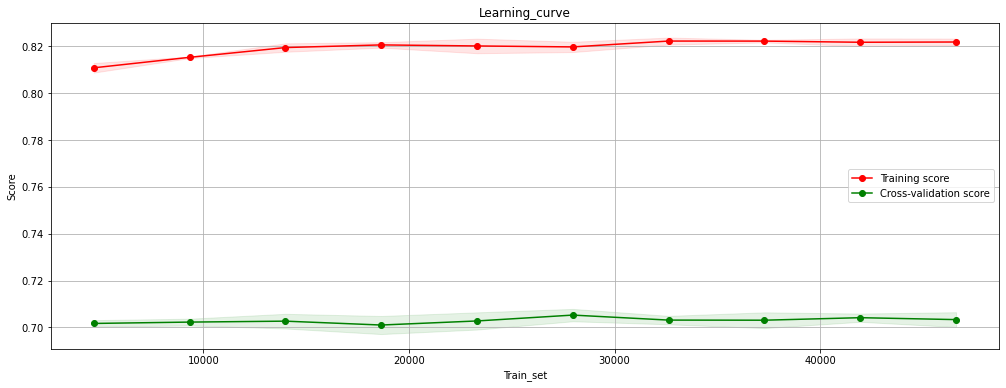

In [50]:
RF_best = gridcv_rf.best_estimator_
evaluation(RF_best)

#### Interpretation
- Matrice de confusion
>Nous avons à peu près un tier de mauvaises prédictions aussi bien pour les matchs gagnés que les matchs perdus. Les bonnes prédictions sont plus équlibrées entre les matchs gagnés et les matchs perdus. 
    
- Classification report
>On observe une précision, un recall et un f1-score convenables en correspondance avec la matrice de confusion, sans augmentation par rapport au résultats obtenus avec les hyperparamètres non optimisés.

- Learning-curve
>A partir d'un train_set d'environ 15000 valeurs, les résultats restent identiques. Le score du train_set est bon on a réussi à diminuer l’overfitting en utilisant la cross validation. le score du test_set est moins bon mais reste acceptable.

####  Courbes ROC

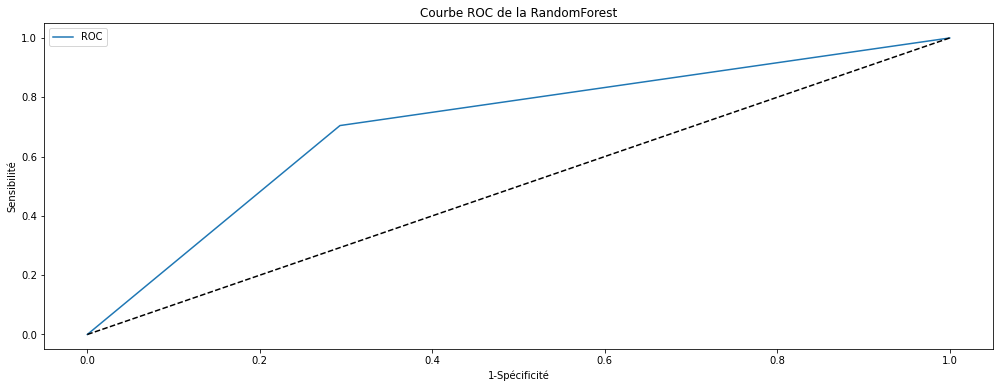

In [51]:
y_pred = RF_best.predict(X_test)
fper, tper, thresholds = roc_curve(y_test, y_pred)

affichage_roc(fper,tper,'1-Spécificité','Sensibilité','ROC','Courbe ROC de la RandomForest')

#### Interpretation
La courbe ROC confirme la qualité du modèle. Elle montre que le modèle est meilleur qu'un tri aléatoire (AUC>0.5)

## KNN

Matrice de confusion :
Classe prédite   0.0   1.0
Classe réelle             
0.0             4874  2799
1.0             2868  4996

 
 Classification Report :
              precision    recall  f1-score   support

         0.0       0.63      0.64      0.63      7673
         1.0       0.64      0.64      0.64      7864

    accuracy                           0.64     15537
   macro avg       0.64      0.64      0.64     15537
weighted avg       0.64      0.64      0.64     15537



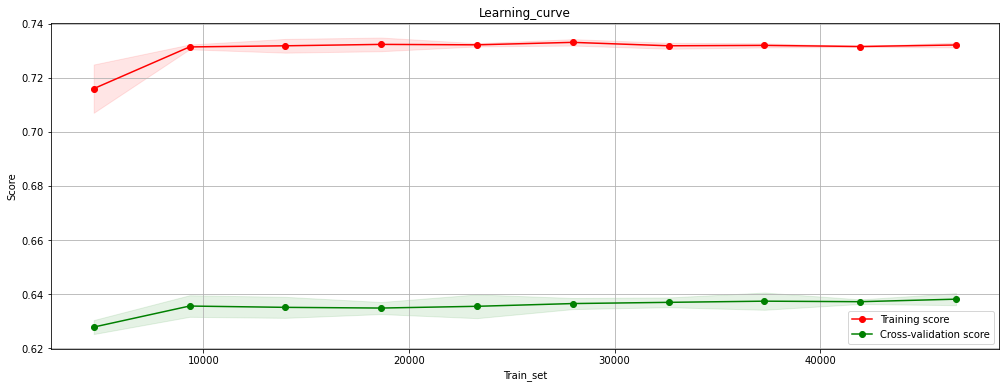

In [52]:
knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski')

evaluation(knn)

#### Interpretation
- Matrice de confusion
>Nous avons à peu près 40% de mauvaises prédictions aussi bien pour les matchs gagnés que les matchs perdus.
    
- Classification report
>On observe une précision, un recall et un f1-score convenables en correspondance avec la matrice de confusion.

- Learning-curve
>A partir d'un train_set d'environ 10000 valeurs, les résultats restent identiques. Le score du train_set est bon sans être en overfitting, le score du test_set est moins bon mais reste acceptable.

### Optimisation du modèle

In [53]:
params_knn = {'n_neighbors': [i for i in range(40,200,10)], 'metric' : ['minkowski','manhattan']}

gridcv_knn = GridSearchCV(knn, param_grid=params_knn, scoring='accuracy', cv=4,n_jobs=-1).fit(X_train, y_train)

In [54]:
print('\n \n best_param ',gridcv_knn.best_params_)


 
 best_param  {'metric': 'manhattan', 'n_neighbors': 180}


### Application des best_params

Matrice de confusion :
Classe prédite   0.0   1.0
Classe réelle             
0.0             5197  2476
1.0             2688  5176

 
 Classification Report :
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67      7673
         1.0       0.68      0.66      0.67      7864

    accuracy                           0.67     15537
   macro avg       0.67      0.67      0.67     15537
weighted avg       0.67      0.67      0.67     15537



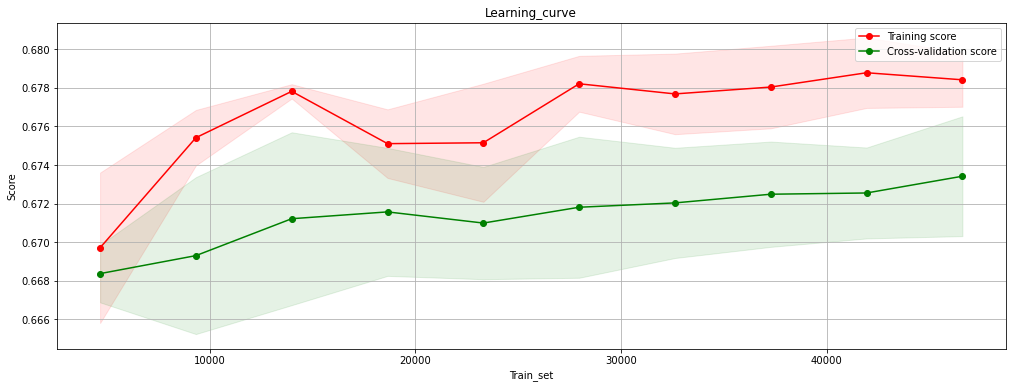

In [55]:
knn_best = gridcv_knn.best_estimator_

evaluation(knn_best)

#### Interpretation
- Matrice de confusion
>Nous avons un peu plus d'un tiers de mauvaises prédictions aussi bien pour les matchs gagnés que les matchs perdus.
 Nous avons un peu plus d'un tiers de mauvaises prédictions aussi bien pour les matchs gagnés que les matchs perdus. La matrice  est équilibrée.
 On a une amélioration sensible grâce à l'optimisation des hyperparamètres.
    
- Classification report
>On observe une précision, un recall et un f1-score convenables en correspondance avec la matrice de confusion en augmentation de 0.04%.

- Learning-curve
>A partir d'un train_set d'environ 25000 valeurs, les résultats restent identiques. Le score du train_set est bon sans être en overfitting, le score du test_set est moins bon mais reste acceptable. L'écart entre les deux est proche.

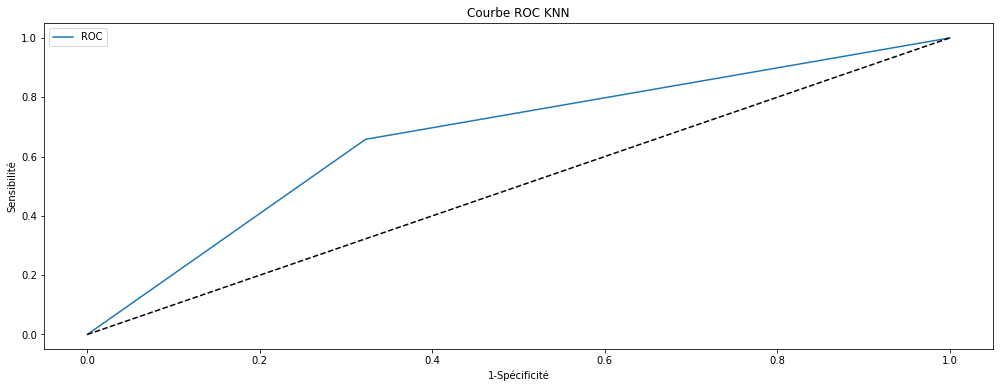

In [56]:
# Courbe ROC pour KNN
y_pred = knn_best.predict(X_test)
fper, tper, thresholds = roc_curve(y_test, y_pred)
affichage_roc(fper,tper,'1-Spécificité','Sensibilité','ROC','Courbe ROC KNN')

#### Interpretation
La courbe ROC confirme la qualité du modèle. Elle montre que le modèle est meilleur qu'un tri aléatoire (AUC>0.5)

## AdaBoost

Matrice de confusion :
Classe prédite   0.0   1.0
Classe réelle             
0.0             5340  2333
1.0             2167  5697

 
 Classification Report :
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70      7673
         1.0       0.71      0.72      0.72      7864

    accuracy                           0.71     15537
   macro avg       0.71      0.71      0.71     15537
weighted avg       0.71      0.71      0.71     15537



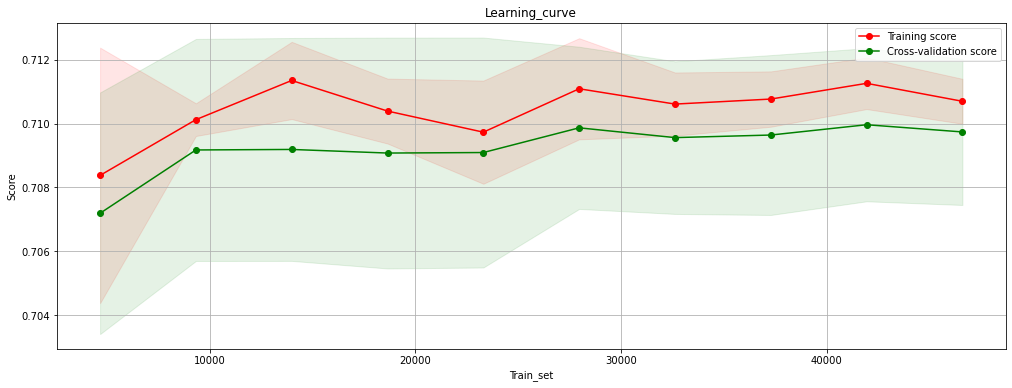

In [57]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 40, learning_rate = 0.5)

evaluation(ada_clf)

#### Interpretation
- Matrice de confusion
>Nous avons près d'un tiers de mauvaises prédictions aussi bien pour les matchs gagnés que les matchs perdus.
    
- Classification report
>On observe une précision, un recall et un f1-score convenables en correspondance avec la matrice de confusion.

- Learning-curve
>A partir d'un train_set d'environ 25000 valeurs, les résultats restent à peu près identiques. Le score du train_set est bon sans être en overfitting, le score du test_set est moins bon mais reste acceptable. L'écart entre les deux est proche.

### Optimisation du modèle

In [58]:
params_ada = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }

gridcv_ada = GridSearchCV(ada_clf, param_grid=params_ada, scoring='accuracy', cv=4,n_jobs=-1).fit(X_train, y_train)

In [59]:
print('\n \n best_param ',gridcv_ada.best_params_)


 
 best_param  {'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 1}


### Application des best_params

Matrice de confusion :
Classe prédite   0.0   1.0
Classe réelle             
0.0             5340  2333
1.0             2167  5697

 
 Classification Report :
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70      7673
         1.0       0.71      0.72      0.72      7864

    accuracy                           0.71     15537
   macro avg       0.71      0.71      0.71     15537
weighted avg       0.71      0.71      0.71     15537



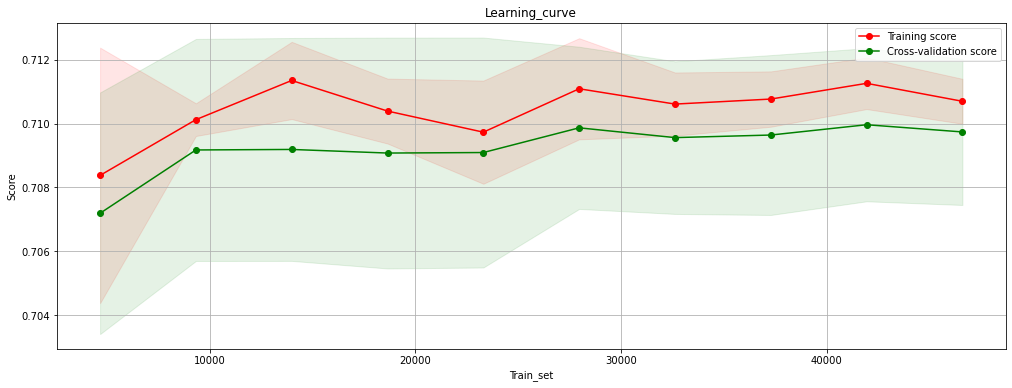

In [60]:
ada_best = gridcv_ada.best_estimator_

evaluation(ada_clf)

#### Interpretation
- Matrice de confusion
>Nous avons près d'un tiers de mauvaises prédictions aussi bien pour les matchs gagnés que les matchs perdus. Il n'y a pas eu d'amélioration en changeant les hyperparamètres.
    
- Classification report
>On observe une précision, un recall et un f1-score convenables en correspondance avec la matrice de confusion, sans amélioration en changeant les hyperparamètres.

- Learning-curve
>A partir d'un train_set d'environ 25000 valeurs, les résultats restent identiques. Les scores sont bons sans être en overfitting.

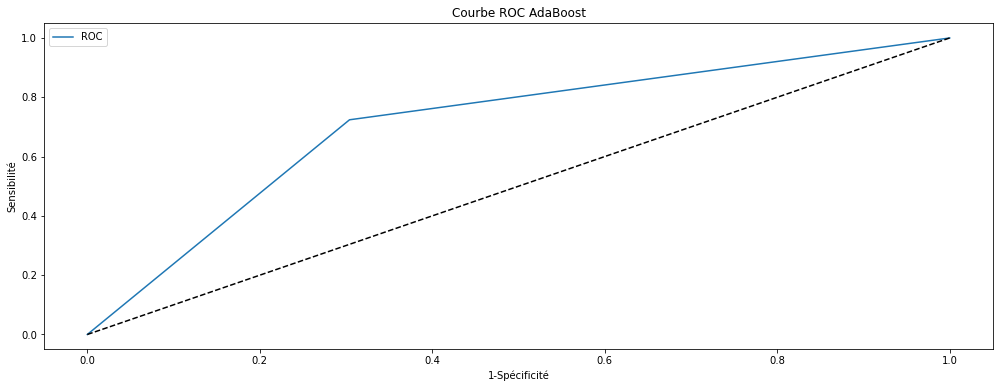

In [61]:
# Courbe ROC pour AdaBoost
y_pred = ada_best.predict(X_test)
fper, tper, thresholds = roc_curve(y_test, y_pred)
affichage_roc(fper,tper,'1-Spécificité','Sensibilité','ROC','Courbe ROC AdaBoost')

#### Interpretation
La courbe ROC confirme la qualité du modèle. Elle montre que le modèle est meilleur qu'un tri aléatoire (AUC>0.5)

## Bagging

Matrice de confusion :
Classe prédite   0.0   1.0
Classe réelle             
0.0             5697  1976
1.0             2681  5183

 
 Classification Report :
              precision    recall  f1-score   support

         0.0       0.68      0.74      0.71      7673
         1.0       0.72      0.66      0.69      7864

    accuracy                           0.70     15537
   macro avg       0.70      0.70      0.70     15537
weighted avg       0.70      0.70      0.70     15537



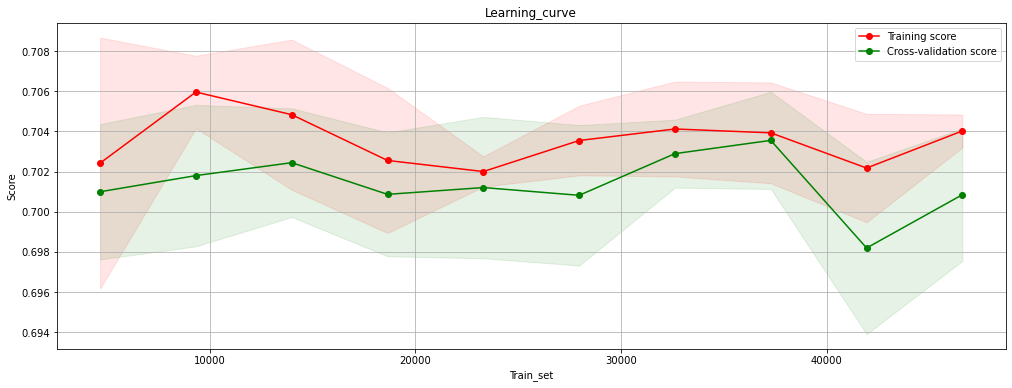

In [62]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 40, max_samples = 100, bootstrap = True, n_jobs = -1, oob_score = True)

evaluation(bag_clf)  

#### Interpretation
- Matrice de confusion
>Nous avons à peu près un tier de mauvaises prédictions aussi bien pour les matchs gagnés que les matchs perdus
    
- Classification report
>On observe une précision, un recall et un f1-score convenables en correspondance avec la matrice de confusion.

- Learning-curve
>Les résultats sont fluctuants mais convergeants lorsque le train_set augmente. Le score du train_set est bon sans être en overfitting, le score du test_set est à peu près équivalent.

### Optimisation du modèle

In [63]:
params_bag = {
    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]}

gridcv_bag = GridSearchCV(bag_clf, param_grid=params_bag, scoring='accuracy', cv=4,n_jobs=-1).fit(X_train, y_train)

In [64]:
print('\n \n best_param ',gridcv_bag.best_params_)


 
 best_param  {'base_estimator__max_depth': 2, 'max_samples': 0.1}


### Application des best_params

Matrice de confusion :
Classe prédite   0.0   1.0
Classe réelle             
0.0             5341  2332
1.0             2170  5694

 
 Classification Report :
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70      7673
         1.0       0.71      0.72      0.72      7864

    accuracy                           0.71     15537
   macro avg       0.71      0.71      0.71     15537
weighted avg       0.71      0.71      0.71     15537



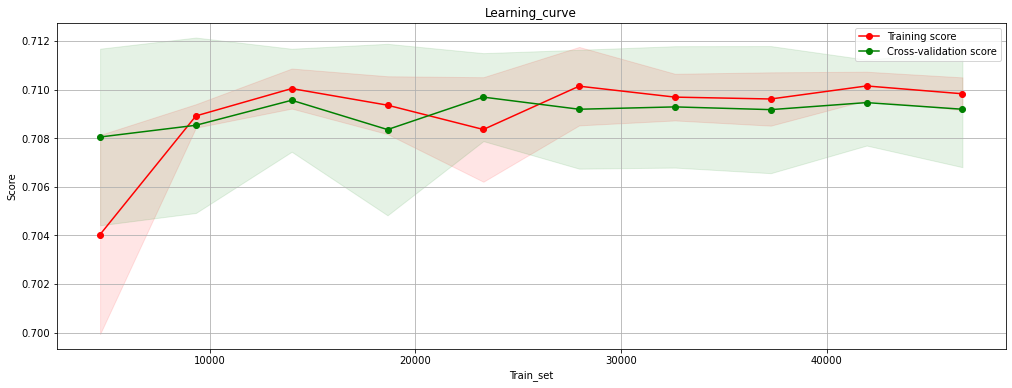

In [65]:
bag_best = gridcv_bag.best_estimator_

evaluation(bag_best)

#### Interpretation
- Matrice de confusion
>Nous avons à peu près un tiers de mauvaises prédictions aussi bien pour les matchs gagnés que les matchs perdus. La
matrice de confusion est plus équilibrée entre les bonnes prédictions de matchs gagnés et les bonnes prédictions de matchs perdus.

- Classification report
>On observe une précision, un recall et un f1-score convenables en correspondance avec la matrice de confusion, mais en baisse par rapport au modèle non optimisé.

- Learning-curve
>Les résultats sont fluctuants mais restent dictinct entre le train_set et le test_set. Le score du train_set est bon sans être en overfitting, le score du test_set est moins bon mais reste acceptable. L'écart entre les deux est réduit.

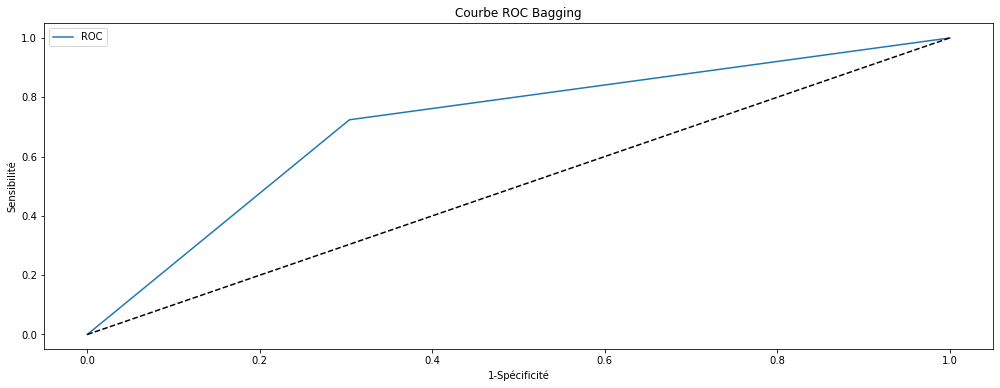

In [66]:
# Courbe ROC pour Bagging
y_pred = bag_best.predict(X_test)
fper, tper, thresholds = roc_curve(y_test, y_pred)
affichage_roc(fper,tper,'1-Spécificité','Sensibilité','ROC','Courbe ROC Bagging')

#### Interpretation
La courbe ROC confirme la qualité du modèle. Elle montre que le modèle est meilleur qu'un tri aléatoire (AUC>0.5)

## Scénario alternatif - Moyennes roulantes

### Moyennes roulantes avec AdaBoost
La moyenne roulante est faite sur les colonnes Wsets et Lsets. Pour réaliser cette opération, il faut trier le dataset par joueur, puis calculer la moyenne roulante par joueur pour le nombre de d'observations voulues. Ici la moyenne roulante est calculée pour 5 observations.

In [67]:
# tri du dataset par joueur
data_roulante = data_roulante.sort_values(by=['Player']).reset_index(drop=True)

n=5 # nombre d'observations prises en comptes pour le calcul de la moyenne

for i in range(1, len(data_roulante)):
    
    # moyenne calculée par joueur
    if data_roulante.loc[i, 'Player'] == data_roulante.loc[i-1, 'Player']:
                   
        # calcul de la moyenne pour les colonnes 12 (Wsets) et 13 (Lsets)
        for colname in data_roulante.columns[[12,13]]:
            data_roulante.loc[i, colname] = data_roulante.loc[max(0, i-n):(i-1), colname].mean()

## Transformation des variables objets en variables numériques

In [68]:
data_roulante['Series'] = le.fit_transform(data_roulante['Series'].astype(str))
data_roulante['Court'] = le.fit_transform(data_roulante['Court'].astype(str))
data_roulante['Tournament'] = le.fit_transform(data_roulante['Tournament'].astype(str))
data_roulante['Surface'] = le.fit_transform(data_roulante['Surface'].astype(str))
data_roulante['Round'] = le.fit_transform(data_roulante['Round'].astype(str))

In [69]:
# suppression des colonnes inutiles ou redondantes
data_roulante=data_roulante.drop(['Date','Location','Comment','proba_elo','Winner','Loser','Player'],axis=1)

In [70]:
# Création d'un ensemble d'entraînement et d'un ensemble test
X_train, X_test, y_train, y_test = train_test_split(data_roulante, target, test_size=0.2)

Matrice de confusion :
Classe prédite   0.0   1.0
Classe réelle             
0.0             6658  1120
1.0               84  7675

 
 Classification Report :
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      7778
         1.0       0.87      0.99      0.93      7759

    accuracy                           0.92     15537
   macro avg       0.93      0.92      0.92     15537
weighted avg       0.93      0.92      0.92     15537



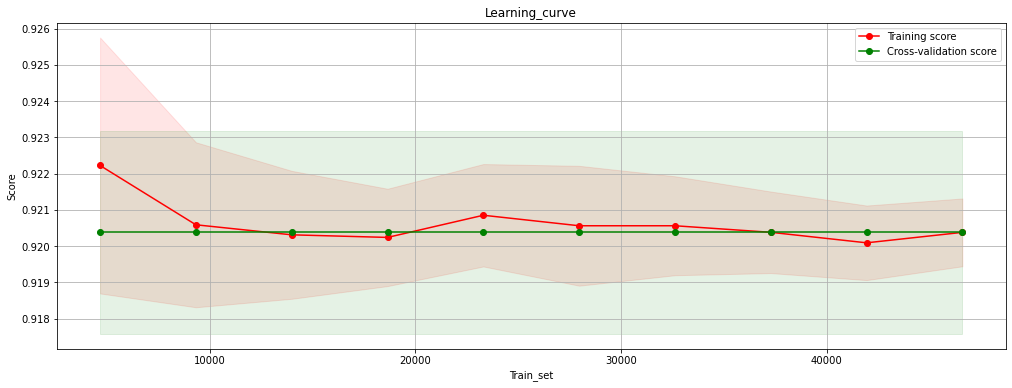

In [71]:
ada_mr = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 1, learning_rate = 0.5)

evaluation(ada_mr)

#### Interpretation
- Matrice de confusion
>Nous avons une matrice très déséquilibrée. Pour les défaites, nous avons 14% de mauvaises prédictions et 1% de mauvaises prédictions pour les victoires.

- Classification report
>On observe une précision, un recall et un f1-score très élevé.

- Learning-curve
>Le score du train_set est fluctuant autour de 0.9205. Le score du test_set est identique. Manifestement ce modèle est en overfitting.

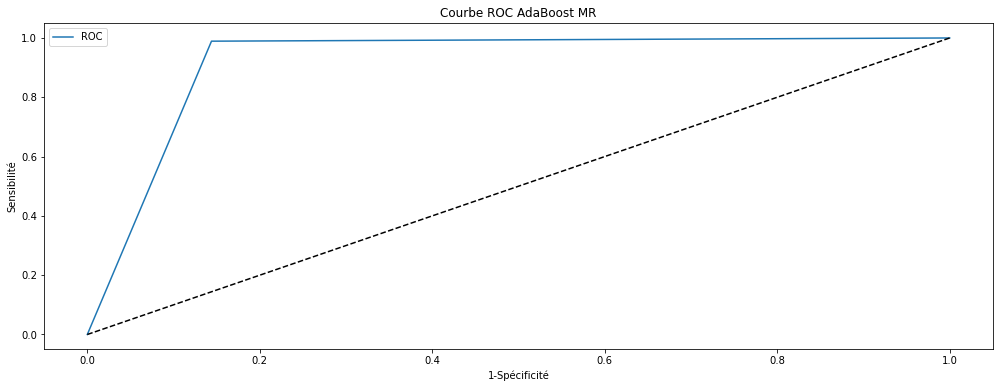

In [72]:
# Courbe ROC pour AdaBoost MR
y_pred = ada_mr.predict(X_test)
fper, tper, thresholds = roc_curve(y_test, y_pred)
affichage_roc(fper,tper,'1-Spécificité','Sensibilité','ROC','Courbe ROC AdaBoost MR')

#### Interpretation
La courbe ROC montre que le modèle est nettement meilleur qu'un tri aléatoire (AUC>0.5).

Après avoir testé ces modèles de classification, nous obtenons de bien meilleurs résultats pour ce scénario plutôt que le scénario 1 donc le scénario 2 est le meilleur choix. Nous allons désormais procéder à une simulations de paris.

# Paris

In [92]:
labelencoder = LabelEncoder()

data_paris['Series'] = labelencoder.fit_transform(data_paris['Series'].astype(str))
data_paris['Court'] = labelencoder.fit_transform(data_paris['Court'].astype(str))
data_paris['Tournament'] = labelencoder.fit_transform(data_paris['Tournament'].astype(str))

data_paris['Surface'] = labelencoder.fit_transform(data_paris['Surface'].astype(str))
data_paris['Round'] = labelencoder.fit_transform(data_paris['Round'].astype(str))
data_paris=data_paris.drop(['Location','Date','Winner', 'Wsets','Lsets','Comment','proba_elo','Loser', 'good_prediction_PS','good_prediction_b365','Player'],axis=1)

In [93]:
#On  conserve années 2018
df_2018 = data_paris[data_paris.Year==2018]
df_2018 = df_2018.sample(frac=1).reset_index(drop=True)


#On enlève les 2018 de l'échantillon entrainement
df_data = data_paris.drop(data_paris[data_paris.Year==2018].index)

In [97]:
target = df_data['target']
data = df_data.drop('target', axis = 1)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

In [99]:
RF_clf = RandomForestClassifier(n_estimators=40)

RF_clf.fit(X_train, y_train)

RF_predictions = RF_clf.predict(X_test)

In [100]:
df_2018_sample = df_2018.loc[:99]

df_2018_sample_test = df_2018_sample.drop('target', axis = 1)

In [101]:
y_pred_proba_2018 = RF_clf.predict_proba(df_2018_sample_test)

In [102]:
y_pred_2018 = RF_clf.predict(df_2018_sample_test)

Nous définissons une fonction simluation_paris qui va simuler les paris d'un parieur sur un tirage aléatoire de 100 matchs de 2018.

Ce dernier va miser uniquement sur les matchs avec une probabilité élevé (sureté à 0.8).

On note ici que les mises effectuées sont indépendantes de la cagnotte (gains ou pertes réalisés).

In [103]:
def simulation_paris(base_cagnotte=0, mise_min=100, mise_max=1000, sureté=0.80):
    
    cagnotte = base_cagnotte
    
    mise_totale = 0
    
    tableau_paris=[]

    for i, probas in enumerate(y_pred_proba_2018):

            cotes_B365_J1 = df_2018_sample['first_odds'][i]
            cotes_B365_J2 = df_2018_sample['second_odds'][i]

            if probas[0]>sureté:
                if df_2018_sample['target'][i] ==0:
                    
                    mise = round(mise_min+(mise_max-mise_min)*(probas[0]-sureté)/(1-sureté))
                    resultat = round(mise *(cotes_B365_J2-1))
                    
                    print('index ',i,' parier {}€ sur victoire du Joueur 1  -'.format(mise) ,
                          ' cote à {} -'.format(cotes_B365_J2),
                          'résultat : {}€'.format(resultat))
                          
                    cagnotte = round(cagnotte + resultat)
                    
                    
                else:
                          
                    mise = round(mise_min+(mise_max-mise_min)*(probas[0]-sureté)/(1-sureté))
                    resultat = round(-mise)
                          
                    print('index ',i,' parier {}€ sur victoire du Joueur 1 -'.format(mise) ,
                          ' cote à {} -'.format(cotes_B365_J2),
                          'résultat perte : {}€'.format(resultat))
                    cagnotte = round(cagnotte + resultat)
                          
                mise_totale += round(mise_min+(mise_max-mise_min)*(probas[0]-sureté)/(1-sureté))
                
                j = (i, probas[0], mise, cotes_B365_J2, resultat, cagnotte, mise_totale)
                tableau_paris.append(j)

            if probas[1]>sureté:
                if df_2018_sample['target'][i]==1:
                    
                    mise = round(mise_min+(mise_max-mise_min)*(probas[1]-sureté)/(1-sureté))
                    resultat = round(mise*(cotes_B365_J1-1))
                               
                          
                    print('index ',i,' parier {}€ sur victoire du Joueur 2 -'.format(mise) ,
                          ' cote à {} -'.format(cotes_B365_J1),
                          'résultat : {}€'.format(resultat))
                    cagnotte = cagnotte + resultat
                          
                else:
                          
                    mise = round(mise_min+(mise_max-mise_min)*(probas[1]-sureté)/(1-sureté))
                    resultat = round(-mise)
                    
                    print('index ',i,' parier {}€ sur victoire du Joueur 2 -'.format(mise),
                          ' cote à {} -'.format(cotes_B365_J1),
                          'résultat perte : {}€'.format(resultat))
                    cagnotte = round(cagnotte + resultat)
                          
                mise_totale += round(mise_min+(mise_max-mise_min)*(probas[1]-sureté)/(1-sureté))
                
                j = (i, probas[1], mise, cotes_B365_J1, resultat, cagnotte, mise_totale)
                tableau_paris.append(j)
                
    print("La mise totale a été de ", mise_totale, '\n \n')
    tab_paris = pd.DataFrame(tableau_paris, columns =['index','probas','mise', 'cote_joueur', 'gain','cagnotte','mise_totale'])
    print(tab_paris,'\n')
    print('RoI: ',round(tab_paris['cagnotte'].iloc[-1]/tab_paris['mise_totale'].iloc[-1],3))

In [104]:
simulation_paris()

index  2  parier 775€ sur victoire du Joueur 1  -  cote à 1.22 - résultat : 170€
index  4  parier 437€ sur victoire du Joueur 2 -  cote à 1.25 - résultat : 109€
index  7  parier 550€ sur victoire du Joueur 2 -  cote à 1.16 - résultat : 88€
index  20  parier 1000€ sur victoire du Joueur 2 -  cote à 1.22 - résultat : 220€
index  22  parier 775€ sur victoire du Joueur 2 -  cote à 1.14 - résultat : 108€
index  46  parier 437€ sur victoire du Joueur 2 -  cote à 1.06 - résultat : 26€
index  51  parier 212€ sur victoire du Joueur 2 -  cote à 1.36 - résultat : 76€
index  54  parier 887€ sur victoire du Joueur 1  -  cote à 1.02 - résultat : 18€
index  59  parier 437€ sur victoire du Joueur 2 -  cote à 1.08 - résultat : 35€
index  62  parier 663€ sur victoire du Joueur 2 -  cote à 1.02 - résultat : 13€
index  63  parier 663€ sur victoire du Joueur 1  -  cote à 1.22 - résultat : 146€
index  66  parier 550€ sur victoire du Joueur 2 -  cote à 1.28 - résultat perte : -550€
index  71  parier 212€ sur

Nous obtenons ici un résultat positif pour une simulation, avec un RoI de 7.2%. 

Pour obtenir un résultat sur le RoI plus significatif nous allons réitéré cette simulation plusieurs fois et dégager un RoI moyen. 

In [109]:
def resultat_plusieurs_simulations(base_cagnotte=0, mise_min=100, mise_max=1000, sureté=0.80):
    
    resultat_ligne = []
    tab_resultat = []
    
    #on effectue plusieurs simulations
    for iteration in range(500):
        
        
        #a chaque fois on randomise un nouvelle échantillon
        df_2018 = data_paris[data_paris.Year==2018]
        df_2018 = df_2018.sample(frac=1).reset_index(drop=True)
        
        RF_clf.fit(X_train, y_train)

        RF_predictions = RF_clf.predict(X_test)


        #J'enleve les 2018 de l'échantillon entrainement
        df_data = data_paris.drop(data_paris[data_paris.Year==2018].index)


        y_pred_proba_2018 = RF_clf.predict_proba(df_2018_sample_test)

        cagnotte = base_cagnotte

        mise_totale = 0

        tableau_paris=[]

        for i, probas in enumerate(y_pred_proba_2018):

                cotes_B365_J1 = df_2018_sample['first_odds'][i]
                cotes_B365_J2 = df_2018_sample['second_odds'][i]

                if probas[0]>sureté:
                    if df_2018_sample['target'][i] ==0:

                        mise = round(mise_min+(mise_max-mise_min)*(probas[0]-sureté)/(1-sureté))
                        resultat = round(mise *(cotes_B365_J2-1))

                        cagnotte = round(cagnotte + resultat)


                    else:

                        mise = round(mise_min+(mise_max-mise_min)*(probas[0]-sureté)/(1-sureté))
                        resultat = round(-mise)

                       
                        cagnotte = round(cagnotte + resultat)

                    mise_totale += round(mise_min+(mise_max-mise_min)*(probas[0]-sureté)/(1-sureté))

                    j = (i, probas[0], mise, cotes_B365_J2, resultat, cagnotte, mise_totale)
                    tableau_paris.append(j)

                if probas[1]>sureté:
                    if df_2018_sample['target'][i]==1:

                        mise = round(mise_min+(mise_max-mise_min)*(probas[1]-sureté)/(1-sureté))
                        resultat = round(mise*(cotes_B365_J1-1))

                        cagnotte = cagnotte + resultat

                    else:

                        mise = round(mise_min+(mise_max-mise_min)*(probas[1]-sureté)/(1-sureté))
                        resultat = round(-mise)

                        
                        cagnotte = round(cagnotte + resultat)

                    mise_totale += round(mise_min+(mise_max-mise_min)*(probas[1]-sureté)/(1-sureté))

                    j = (i, probas[1], mise, cotes_B365_J1, resultat, cagnotte, mise_totale)
                    tableau_paris.append(j)
                    
                    tab_paris = pd.DataFrame(tableau_paris, columns =['index','probas','mise', 'cote_joueur', 'gain','cagnotte','mise_totale'])
                    
                    ROI = round(tab_paris['cagnotte'].iloc[-1]/tab_paris['mise_totale'].iloc[-1],3)
       
    

        #indique le RoI, la cagnotte, et la mise totale par simulation de paris
        ligne_resultat = (ROI, tab_paris['cagnotte'].iloc[-1], tab_paris['mise_totale'].iloc[-1])
        print(ligne_resultat)



In [110]:
resultat_plusieurs_simulations()

#cette fonction effectue 500 simulations 
#tuple (RoI, Résultat, mise_totale)

(0.062, 584, 9435)
(0.02, 155, 7673)
(0.046, 358, 7798)
(0.026, 222, 8546)
(0.123, 1289, 10447)
(0.07, 554, 7898)
(0.077, 608, 7923)
(0.027, 257, 9422)
(0.108, 953, 8797)
(-0.037, -332, 8910)
(0.153, 924, 6034)
(0.119, 995, 8359)
(0.098, 928, 9447)
(-0.008, -66, 8800)
(0.146, 1110, 7598)
(0.023, 171, 7598)
(-0.018, -125, 7123)
(-0.042, -333, 7910)
(-0.02, -160, 7937)
(0.041, 346, 8533)
(0.073, 620, 8484)
(0.104, 819, 7909)
(0.099, 815, 8209)
(0.08, 783, 9796)
(0.11, 806, 7360)
(0.041, 337, 8148)
(0.034, 302, 8785)
(0.142, 918, 6486)
(0.094, 735, 7810)
(0.11, 811, 7347)
(0.111, 1073, 9660)
(-0.01, -86, 8260)
(-0.011, -68, 6135)
(0.079, 519, 6587)
(0.042, 370, 8797)
(0.119, 872, 7347)
(0.087, 539, 6221)
(-0.012, -101, 8698)
(0.04, 369, 9221)
(0.054, 438, 8047)
(0.042, 299, 7122)
(0.178, 1269, 7123)
(-0.043, -348, 8121)
(0.043, 410, 9532)
(0.092, 607, 6573)
(0.101, 1155, 11395)
(0.005, 35, 7320)
(0.109, 1040, 9521)
(0.057, 504, 8798)
(0.114, 926, 8135)
(0.096, 755, 7900)
(0.099, 662, 6696

## Remarque

Les résultats ci-dessus sont des tuples composés de la manière suivante : (RoI, résultat, mise_totale), chaque ligne correspondant à la sortie d'une simulation. 

On remarque qu'on obtient des résultats RoI (return of investisment) à la positifs et négatifs. Nous pouvons observer que la grande majorité des RoI sont positifs mais que certaines sorties sont négatives, ce qui signifie que dans certains cas, il est possible d'obtenir des pertes au total. Plus précisement, sur 500 itérations, seulement 35 ont un RoI négatif, soit 7% de toutes les simulations. 

D'après les résultats de la fonction (500 itérations) nous obtenons un RoI moyen de plus de 8%, néanmoins sur une simulation antérieure nous avons pu obtenir un RoI moyen à 7.5%, donc inférieur. 

# Conclusion

## Itération 1 - Découverte du dataset

- Le dataset initial contient 23 colonnes et 44 708 lignes
- Les colonnes elos sont calculées.
- Dans plusieurs colonnes nous avons des valeurs manquantes et en particulier dans les colonnes de cotations pour les premières années.
- Il y a quelques valeurs aberrantes dans certaines colonnes.
- Les colonnes des deux bookmakers sont étroitement corrélées.
- La colonne ATP n'a aucune corrélation avec les autres variables.
- Le nombre de matchs par année varie fortement. Nous n'avons pas d'explications pour justifier ces écarts.
- En comparant le top 10 des gagnants et le top 10 des perdants par nombre de matchs, nous nous aperçevons que 2 noms sont communs. Nous pensons que les joueurs de haut niveau disputent plus de matchs que les autres.
- Le nombre de tournoi par surface montre clairement que la surface prédominante est le dur.
- Par rapport au nombre de matchs gagnés par surface et par joueurs, il apparaît que certains joueurs sont polyvalents alors que d'autres ont plus de réussite sur un type de surface.
- Le taux de bonnes prédictions des bookmakers, pour les données disponibles (hors valeurs manquantes), est de l'ordre de 70%

## Itération 1 - Recherche d'un scénario et d'une cible

Le dataset initial a été élaboré pour estimer le ROI par rapport à une stratégie de paris basée sur les cotations des bookmakers. La cible était donc en dehors du dataset. Il en résulte que nous avons du trouver une cible pour le Machine Learning.

Dans un premier scénario, nous avons voulu prendre une colonne du dataset comme cible. Il est apparu qu'aucune des colonnes ne synthétise à la fois le résultat du gagnant et celui du perdant. Il a donc fallu réorganiser le dataset pour ce premier scénario.

Dans un second scénario, nous avons voulu avoir pour cible le résultat du match. Pour ce scénario, il a fallu également réorganiser le dataset et créer une nouvelle target.

## Itération 1 - Traitement et réorganisation du dataset

### Traitement des valeurs manquantes
Dans un premier temps, nous avons essayé de générer les valeurs manquantes des colonnes cotations à partir des elos des jours, mais cette solution n'a pas été retenue car il y a trop de différences entre les elos et les cotes (niveau de corrélation max=0,5).
En analysant les valeurs manquantes par année, nous nous sommes aperçu que seules certaines années étaient impactées. Nous avons donc décidé de supprimer les lignes pour ces années uniquement soit 10% du dataset.
Nous avons remplacé les autres valeurs manquantes par la modalité la plus fréquente de la colonne.

### Suppression des colonnes fortement corrélées ou sans corrélation
Nous avons supprimé la colonne ATP et les 2 colonnes du bookmaker PINNACLE fortement corrélé avec B365. Par ailleurs, il manquait beaucoup plus de cotes dans les colonnes PINNACLE que celles B365.

### Suppression des outliers
Au regard de la répartition des valeurs affichées dans les boxplots, nous avons supprimé certaines valeurs qui nous semblaient trop 'distantes'.

### Pour le scénario 1
Pour ce scénario, nous avons normalisé les données numériques. Nous avons transformé les variables catégorielles via la commande dummies.
Nous avons du réorganiser le dataset pour avoir dans une même colonne les informations des gagnants et celles des perdants. La cible choisie était le Rank des joueurs dont les valeurs étaient les plus représentatives par rapport aux résultats des matchs. Dans ce scénario, les noms des joueurs étaient supprimés.


### Pour le scénario 2 
Nous avons choisi de transformer les variables catégorielles avec LabelEncoder qui ne génèrent pas de colonnes supplémentaires par rapport à dummies.
Nous avons réorganisé  le dataset pour avoir une colonne target en fonction du gagnant et du perdant. Pour faire cette distinction, il a fallu doubler le dataset et attribuer la valeur 1 pour les gagnants et la valeur 0 pour les perdants.
Pour garder l'information sur les joueurs, nous avons remplacé les noms par un id unique.

## Itération 1 - Modélisation

### Analyses complémentaires
#### Test du chi2 (variables qualitatives)
Les variables sont toutes liées entre-elles sauf les variables Comment et court ainsi que Surface et Comment.

#### ACP
Avec 3 composantes, nous pouvons avoir un taux de représentativité de 80,1%. Nous n'avons pas cependant retenu cette solution du fait que le dataset contient peu de variables et que nous pensons avoir plus de possibilités pour optimiser nos modèles.

#### ANOVA
Pour avoir une idée des relations entre variables numériques, nous avons fait un test ANOVA sur une partie des variables et constaté qu'elles sont toutes liées entre elles.

### Modélisation pour le scénario 1
Nous avons fait des tests en prenant la colonne rank comme cible, c'est la colonne qui était la plus juste par rapport aux résultats des matchs.
Nous avons testé RidgeCV et LinearRegression.

### Modélisation pour le scénario 2
Nous avons testé les modèles RandomForest, KNN, AdaBoost et Bagging.

## Itération 1 - Analyse des résultats /objectif

#### Pour le scénario 1
RidgeCV
- Nous avons obtenu un score de 0.24

LinearRegression
- Nous avons obtenu un score de 0.24

#### Pour le scénario 2
RandomForest
- Nous avons obtenu un score de 0.71

KNN
- Nous avons obtenu un score de 0.67

AdaBoost
- Nous avons obtenu un score de 0.71

Bagging
- Nous avons obtenu un score de 0.71

Les tests que nous avons menés sur la structure du dataset montrent que la structure prise pour le modèle AdaBoost est la plus appropriée. Nous privilégions le modèle qui a le meilleur score dans le Rappel, et particulièrement pour la classe 1, c'est-à-dire sa capacité à prédire les matchs gagnés.
 

C'est ce scénario que nous avons choisi pour la suite de notre étude.

## Itération 2 - Analyse des résultats /objectif

Avec le dataset établi lors de l'itération 1, nous avons décidé de tester plusieurs algorithmes et d'optimiser pour chacun les hyperparamètres.

||scores sans optimisation|scores avec optimisation|commentaires|
|:-|:-:|:-:|:-|
|RandomForest|0.70|0.71|amélioration de 0.01|
|KNN|0.64|0.67|amélioration très sensible|
|AdaBoost|0.71|0.71|pas d'amélioration du score|
|Bagging|0.70|0.71|amélioration de 0.01|

## Scénario alternatif - Moyennes roulantes

Le score est haut par rapport aux résultats des autres modèles. Il faudrait faire une analyse plus approfondie pour comprendre le résultat.

## Reflexions sur la démarche / contexte

Nous avons testé 2 scénarios, plusieurs configurations de dataset et enfin plusieurs algorithmes.

Sans expérience, cette démarche nous semble appropriée. Néanmoins elle est chronophage. Au regard des résultats, on peut se demander s'il est nécessaire de tester autant de modèles.

Il est certains que notre code n'est pas optimisé, ni par la structure, ni par le temps de traitement. Nous aurions pu utiliser des pipelines pour 'automatiser' les traitements.


Ce projet nous a permis de sortir du cadre formalisé du contexte d'apprentissage en nous obligeant à déterminer une méthode pour aboutir à l'objectif. En ce sens, elle représente une première expérience appréciable.